--- INITIATING DUAL-LAYER OPTIMIZATION (15 Defense + 10 Perimeter) ---
🎯 Target Set A (Assets): 20638 Cells.
🎯 Target Set B (Wildland): 18349 Cells.

⚙️ Layer 1: Calculating Asset Defense Centers...
⚙️ Layer 2: Calculating Wildland Perimeter Early Warning Centers...
✅ OPTIMIZATION COMPLETE: Total 25 Sensors Finalized.

💾 SENSOR DEPLOYMENT PLAN SAVED: ../data/processed/optimized_sensor_network.csv

📊 Generating Dual-Layer Sensor Network Map...


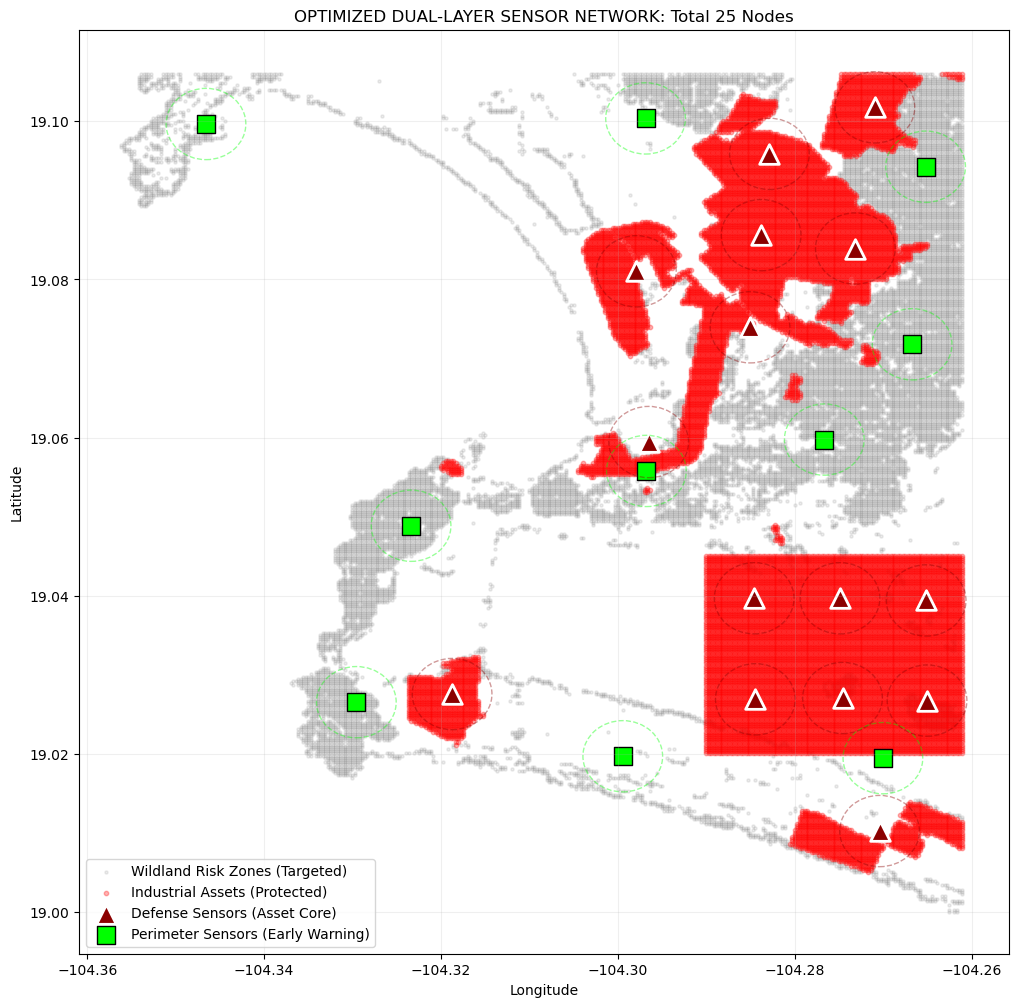

In [2]:
# =============================================================================
# 08_Sensor_Network_Optimization.ipynb - REVISED DUAL-LAYER STRATEGY
# PHASE: PREVENT (Sensor Deployment Optimization)
# OBJECTIVE: Maximize coverage of (1) Industrial Assets AND (2) Wildland Ignition Zones.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from geopy.distance import geodesic 
import os

# --- 1. CONFIGURATION ---
TOTAL_SENSORS = 25           # Total budget for IOT sensor deployment
ASSET_PROTECTION_RATIO = 0.6 # 60% of sensors for Industrial Assets
PERIMETER_RATIO = 0.4        # 40% of sensors for Wildland Perimeter
SENSOR_RANGE_M = 500         
WIND_PREVAILING_DEG = 225    # Prevailing Wind (used for Upwind Shift)
WIND_SHIFT_M = 100           
RANDOM_STATE = 42

# Path Handling
if os.path.exists('../data/processed/manzanillo_MASTER_TWIN_DATA.csv'):
    DATA_DIR = '../data/processed/'
else:
    DATA_DIR = 'data/processed/'

INPUT_DATA = DATA_DIR + 'manzanillo_MASTER_TWIN_DATA.csv'
OUTPUT_SENSORS = DATA_DIR + 'optimized_sensor_network.csv'

# Calculate split
N_ASSET_DEFENSE = int(TOTAL_SENSORS * ASSET_PROTECTION_RATIO) # 15 sensors
N_PERIMETER_EARLY = TOTAL_SENSORS - N_ASSET_DEFENSE           # 10 sensors

print(f"--- INITIATING DUAL-LAYER OPTIMIZATION ({N_ASSET_DEFENSE} Defense + {N_PERIMETER_EARLY} Perimeter) ---")

# --- 2. LOAD & FILTER TARGETS ---
try:
    master_twin = pd.read_csv(INPUT_DATA)
    
    # Target Set A: Industrial and Expansion (Highest Priority/Value)
    asset_targets = master_twin[
        (master_twin['fuel_model'] == 'Industrial_Port') | 
        (master_twin['is_future_expansion'] == 1)
    ].copy()
    
    # Target Set B: Wildland Perimeter (Highest Risk/Ignition Potential)
    # Logic: Target cells that are Vegetation AND have high slope (driving spread)
    # AND are not already part of the city/port structure.
    wildland_targets = master_twin[
        (master_twin['fuel_model'] == 'Vegetation') &
        (master_twin['is_structure'] == 0) &
        (master_twin['slope'] > master_twin['slope'].quantile(0.85)) # Top 15% steepest slopes
    ].copy()
    
    print(f"🎯 Target Set A (Assets): {len(asset_targets)} Cells.")
    print(f"🎯 Target Set B (Wildland): {len(wildland_targets)} Cells.")

except FileNotFoundError:
    print("❌ ERROR: Master Data not found. Ensure Notebook 07 ran successfully.")
    raise

# --- 3. CORE OPTIMIZATION ---
all_sensor_locs = []

# --- LAYER 1: ASSET DEFENSE (K-Means on Industrial Targets) ---
if len(asset_targets) >= N_ASSET_DEFENSE:
    print("\n⚙️ Layer 1: Calculating Asset Defense Centers...")
    X_asset = asset_targets[['latitude', 'longitude']].values
    kmeans_asset = KMeans(n_clusters=N_ASSET_DEFENSE, random_state=RANDOM_STATE, n_init=10).fit(X_asset)
    asset_locs = pd.DataFrame(kmeans_asset.cluster_centers_, columns=['latitude', 'longitude'])
    asset_locs['layer'] = 'Asset_Defense'
    all_sensor_locs.append(asset_locs)
else:
    print("⚠️ WARNING: Not enough unique asset targets for full defense deployment.")
    

# --- LAYER 2: WILDLAND PERIMETER (K-Means on High-Slope Ignition Zones) ---
if len(wildland_targets) >= N_PERIMETER_EARLY:
    print("⚙️ Layer 2: Calculating Wildland Perimeter Early Warning Centers...")
    X_wild = wildland_targets[['latitude', 'longitude']].values
    kmeans_wild = KMeans(n_clusters=N_PERIMETER_EARLY, random_state=RANDOM_STATE + 1, n_init=10).fit(X_wild)
    wild_locs = pd.DataFrame(kmeans_wild.cluster_centers_, columns=['latitude', 'longitude'])
    wild_locs['layer'] = 'Wildland_Perimeter'
    all_sensor_locs.append(wild_locs)
else:
    print("⚠️ WARNING: Not enough unique wildland targets for full perimeter deployment.")


# Combine all optimized locations
sensor_locs = pd.concat(all_sensor_locs, ignore_index=True)
sensor_locs['sensor_id'] = [f"{row['layer'].split('_')[0]}_{i:02d}" for i, row in sensor_locs.iterrows()]
print(f"✅ OPTIMIZATION COMPLETE: Total {len(sensor_locs)} Sensors Finalized.")


# --- 4. STRATEGIC WIND SHIFT (APPLIED TO ALL) ---
shift_angle = (WIND_PREVAILING_DEG + 180) % 360 

def shift_coords(row):
    start_point = (row['latitude'], row['longitude'])
    # Geodesic shift is accurate for large distances
    destination = geodesic(meters=WIND_SHIFT_M).destination(start_point, bearing=shift_angle)
    row['latitude'] = destination.latitude
    row['longitude'] = destination.longitude
    return row

# Apply the UPWIND shift
sensor_locs = sensor_locs.apply(shift_coords, axis=1)


# --- 5. SAVE DEPLOYMENT MAP ---
sensor_locs.to_csv(OUTPUT_SENSORS, index=False)
print(f"\n💾 SENSOR DEPLOYMENT PLAN SAVED: {OUTPUT_SENSORS}")

# --- 6. VISUALIZATION ---
print("\n📊 Generating Dual-Layer Sensor Network Map...")
fig, ax = plt.subplots(figsize=(12, 12))

# Background: Wildland Targets
ax.scatter(wildland_targets['longitude'], wildland_targets['latitude'], c='gray', s=5, alpha=0.15, label='Wildland Risk Zones (Targeted)')

# Targets: Industrial Assets
ax.scatter(asset_targets['longitude'], asset_targets['latitude'], c='red', s=10, alpha=0.3, label='Industrial Assets (Protected)')

# Sensors (Color-coded by Layer)
ax.scatter(sensor_locs[sensor_locs['layer'] == 'Asset_Defense']['longitude'], sensor_locs[sensor_locs['layer'] == 'Asset_Defense']['latitude'], 
           c='darkred', s=200, marker='^', edgecolors='white', linewidth=2, label='Defense Sensors (Asset Core)')

ax.scatter(sensor_locs[sensor_locs['layer'] == 'Wildland_Perimeter']['longitude'], sensor_locs[sensor_locs['layer'] == 'Wildland_Perimeter']['latitude'], 
           c='lime', s=150, marker='s', edgecolors='black', linewidth=1, label='Perimeter Sensors (Early Warning)')

# Draw Coverage Circles
for _, row in sensor_locs.iterrows():
    radius_deg = SENSOR_RANGE_M / 111000 
    color = 'darkred' if row['layer'] == 'Asset_Defense' else 'lime'
    circle = plt.Circle((row['longitude'], row['latitude']), radius_deg, 
                        color=color, fill=False, linestyle='--', alpha=0.4)
    ax.add_patch(circle)

plt.title(f"OPTIMIZED DUAL-LAYER SENSOR NETWORK: Total {len(sensor_locs)} Nodes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()